In [23]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from custom import load_data as cf
from custom import ecdf
import warnings
warnings.filterwarnings('ignore')
from nxviz import CircosPlot
import numpy as np


%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

We will load the [sociopatterns network](http://konect.uni-koblenz.de/networks/sociopatterns-infectious) data for this notebook. From the Konect website:

> This network describes the face-to-face behavior of people during the exhibition INFECTIOUS: STAY AWAY in 2009 at the Science Gallery in Dublin. Nodes represent exhibition visitors; edges represent face-to-face contacts that were active for at least 20 seconds. Multiple edges between two nodes are possible and denote multiple contacts. The network contains the data from the day with the most interactions.

In [24]:
# Load the sociopatterns network data. 
G = cf.load_sociopatterns_network()

In [25]:
# How many nodes and edges are present?
len(G.nodes()), len(G.edges())

(410, 2765)

# Hubs: How do we evaluate the importance of some individuals in a network?

Within a social network, there will be certain individuals which perform certain important functions. For example, there may be hyper-connected individuals who are connected to many, many more people. They would be of use in the spreading of information. Alternatively, if this were a disease contact network, identifying them would be useful in stopping the spread of diseases. How would one identify these people?

## Approach 1: Neighbors

One way we could compute this is to find out the number of people an individual is conencted to. NetworkX let's us do this by giving us a `G.neighbors(node)` function.

In [26]:
# Let's find out the number of neighbors that individual #7 has.
len(G.neighbors(7))

7

### Exercise

Can you create a ranked list of the importance of each individual, based on the number of neighbors they have? (3 min.)

Hint: One suggested output would be a list of tuples, where the first element in each tuple is the node ID (an integer number), and the second element is the number of neighbors that it has.

Hint: Python's `sorted(iterable, key=lambda x:...., reverse=True)` function may be of help here.

In [27]:
# Possible Answers:
sorted(G.nodes(), 
       key=lambda x:len(G.neighbors(x)), reverse=True)[0:5]
# sorted([(n, G.neighbors(n)) for n in G.nodes()], 
#        key=lambda x: len(x[1]), reverse=True)[0:5]

[51, 272, 235, 195, 161]

## Approach 2: Degree Centrality

The number of other nodes that one node is connected to is a measure of its centrality. NetworkX implements a **degree centrality**, which is defined as the number of neighbors that a node has normalized to the number of individuals it could be connected to in the entire graph. This is accessed by using `nx.degree_centrality(G)`

In [28]:
list(nx.degree_centrality(G).items())[0:5]

[(100, 0.07090464547677261),
 (101, 0.03178484107579462),
 (102, 0.039119804400977995),
 (103, 0.06356968215158924),
 (104, 0.04156479217603912)]

If you inspect the dictionary closely, you will find that node 51 is the one that has the highest degree centrality, just as we had measured by counting the number of neighbors.

There are other measures of centrality, namely **betweenness centrality**, **flow centrality** and **load centrality**. You can take a look at their definitions on the NetworkX API docs and their cited references. You can also define your own measures if those don't fit your needs, but that is an advanced topic that won't be dealt with here.

The NetworkX API docs that document the centrality measures are here: http://networkx.readthedocs.io/en/networkx-1.11/reference/algorithms.centrality.html?highlight=centrality#module-networkx.algorithms.centrality

### Exercises

The following exercises are designed to get you familiar with the concept of "distribution of metrics" on a graph.

1. Can you create an ECDF of the distribution of degree centralities?
2. Can you create an ECDF of the distribution of number of neighbors?
3. Can you create a scatterplot of the degree centralities against number of neighbors?
4. If I have `n` nodes, then how many possible edges are there in total, assuming self-edges are allowed? What if self-edges are not allowed?

Exercise Time: 8 minutes.

Here is what an ECDF is (https://en.wikipedia.org/wiki/Empirical_distribution_function).

Hint: You may want to use:

    ecdf(list_of_values)
    
to get the empirical CDF x- and y-values for plotting, and 

    plt.scatter(x_values, y_values)
    
Hint: You can access the dictionary `.keys()` and `.values()` and cast them as a list.

If you know the Matplotlib API, feel free to get fancy :).

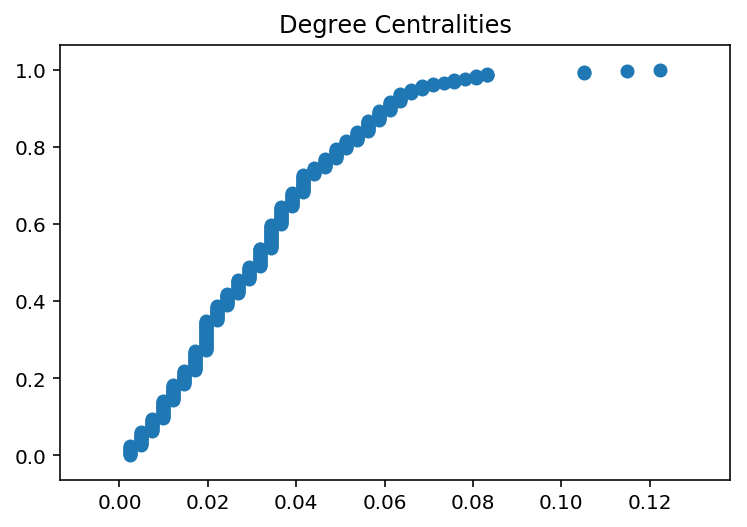

In [29]:
# Possible Answers:
fig = plt.figure(0)
# Get a list of degree centrality scores for all of the 
# nodes in the graph
degree_centralities = list(
    nx.degree_centrality(G).values())
x, y = ecdf(degree_centralities)
# Plot the histogram of degree centralities.
plt.scatter(x, y)
# Set the plot title. 
plt.title('Degree Centralities')

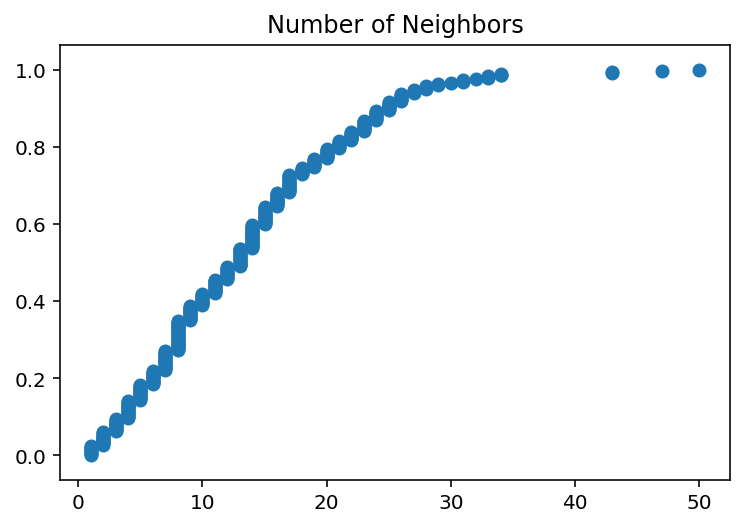

In [30]:
fig = plt.figure(1)
neighbors = [len(G.neighbors(node)) for node in G.nodes()]
x, y = ecdf(neighbors)
plt.scatter(x, y)
plt.title('Number of Neighbors')

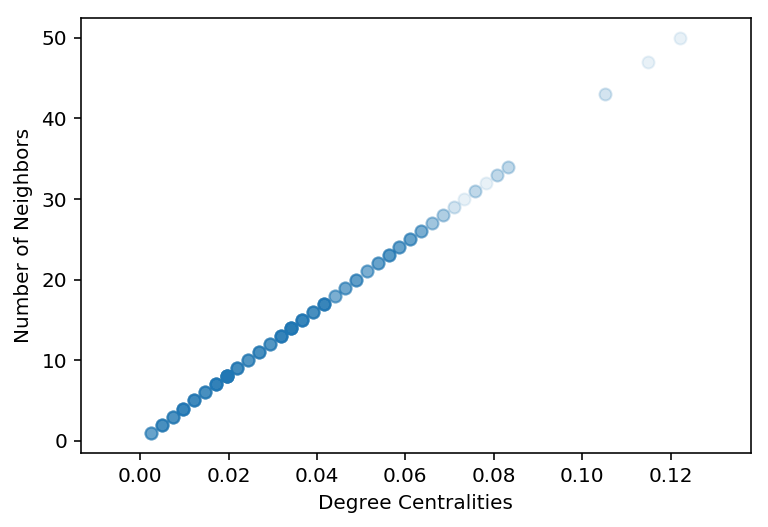

In [31]:
fig = plt.figure(2)
plt.scatter(degree_centralities, neighbors, alpha=0.1)
plt.xlabel('Degree Centralities')
plt.ylabel('Number of Neighbors')

### Exercise

Before we move on to paths in a network, see if you can use the Circos plot to visualize the network. Order and color the nodes according to the `order` keyword. (2 min.)

The CircosPlot API needs documentation written; for now, I am providing the following "on-the-spot" docs for you.

To instantiate and draw a CircosPlot:

```python
c = CircosPlot(G, node_order='node_key', node_color='node_key')
c.draw()
plt.show()  # or plt.savefig(...)
```

Notes:

- `'node_key'` is a key in the node metadata dictionary that the CircosPlot constructor uses for determining the colour, grouping, and ordering of the nodes.
- In the following exercise, you may want to use `order`, which is already encoded on each node in the graph.

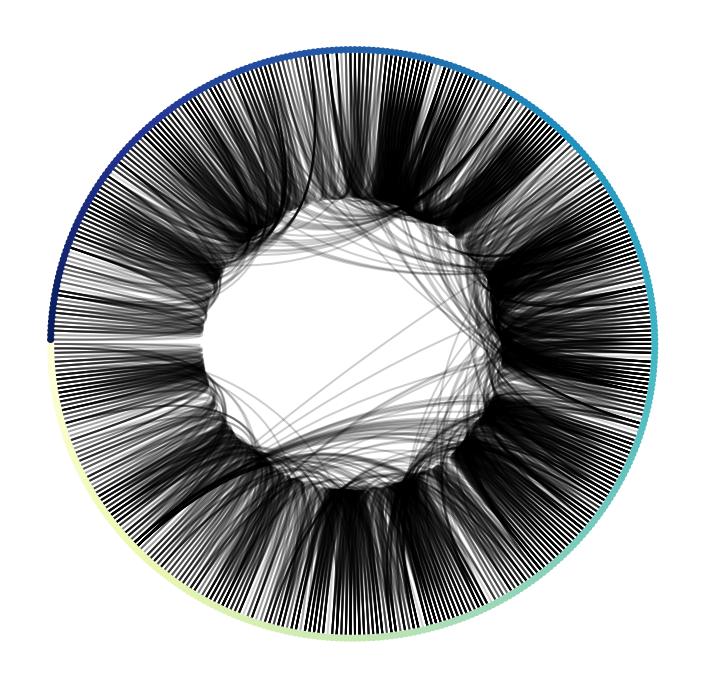

In [32]:
c = CircosPlot(G, node_order='order', node_color='order')
c.draw()
plt.savefig('images/sociopatterns.png', dpi=300)

What can you deduce about the structure of the network, based on this visualization?

Nodes are sorted by ID. Nodes are more connected to proximal rather than distal nodes. The data are based on people streaming through an enclosed space, so it makes sense that people are mostly connected to others proximal in order, but occasionally some oddballs stick around.

# Paths in a Network

Graph traversal is akin to walking along the graph, node by node, restricted by the edges that connect the nodes. Graph traversal is particularly useful for understanding the local structure (e.g. connectivity, retrieving the exact relationships) of certain portions of the graph and for finding paths that connect two nodes in the network. 

Using the synthetic social network, we will figure out how to answer the following questions:

1. How long will it take for a message to spread through this group of friends? (making some assumptions, of course)
2. How do we find the shortest path to get from individual A to individual B?

## Shortest Path

Let's say we wanted to find the shortest path between two nodes. How would we approach this? One approach is what one would call a **breadth-first search** (http://en.wikipedia.org/wiki/Breadth-first_search). While not necessarily the fastest, it is the easiest to conceptualize. 

The approach is essentially as such:

1. Begin with a queue of the starting node.
2. Add the neighbors of that node to the queue.
    1. If destination node is present in the queue, end.
    2. If destination node is not present, proceed.
3. For each node in the queue:
    1. Remove node from the queue.
    2. Add neighbors of the node to the queue. Check if destination node is present or not.
    3. If destination node is present, end. <!--Credit: @cavaunpeu for finding bug in pseudocode.-->
    4. If destination node is not present, continue.

### Exercise

Try implementing this algorithm in a function called `path_exists(node1, node2, G)`. (15 min.)

The function should take in two nodes, `node1` and `node2`, and the graph `G` that they belong to, and return a Boolean that indicates whether a path exists between those two nodes or not. For convenience, also print out whether a path exists or not between the two nodes.

In [33]:
def path_exists(node1, node2, G):
    """
    This function checks whether a path exists between two nodes (node1, node2) in graph G.
    
    Special thanks to @ghirlekar for suggesting that we keep track of the "visited nodes" to
    prevent infinite loops from happening. This also removes the need to remove nodes from
    queue.
    
    Reference: https://github.com/ericmjl/Network-Analysis-Made-Simple/issues/3
    
    With thanks to @joshporter1 for the second bug fix. Originally there was an extraneous "if"
    statement that guaranteed that the "False" case would never be returned - because queue never
    changes in shape. Discovered at PyCon 2017.
    """
    visited_nodes = set()
    queue = [node1]
    
    for node in queue:
        neighbors = G.neighbors(node)
        if node2 in neighbors:
            print('Path exists between nodes {0} and {1}'.format(node1, node2))
            return True
            break
        else:
            visited_nodes.add(node)
            queue.extend([n for n in neighbors if n not in visited_nodes])
    
    print('Path does not exist between nodes {0} and {1}'.format(node1, node2))
    return False
    

In [34]:
# Test your answer below
def test_path_exists():
    assert path_exists(18, 5, G)
    assert path_exists(22, 318, G)
    
test_path_exists()

Path exists between nodes 18 and 5
Path exists between nodes 22 and 318


If you write an algorithm that runs breadth-first, the recursion pattern is likely to follow what we have done above. If you do a depth-first search (i.e. DFS), the recursion pattern is likely to look a bit different. Take it as a challenge exercise to figure out how a DFS looks like.

Meanwhile... thankfully, NetworkX has a function for us to use, titled `has_path`, so we don't have to implement this on our own. :-)

http://networkx.readthedocs.io/en/networkx-1.11/reference/generated/networkx.algorithms.shortest_paths.generic.has_path.html

In [35]:
G.add_node(411)

In [36]:
nx.has_path(G, 400, 1)

True

NetworkX also has other shortest path algorithms implemented. 

http://networkx.readthedocs.io/en/networkx-1.11/reference/algorithms.shortest_paths.html

We can build upon these to build our own graph query functions. Let's see if we can trace the shortest path from one node to another.

`nx.shortest_path(G, source, target)` gives us a list of nodes that exist within one of the shortest paths between the two nodes. (Not all paths are guaranteed to be found.)

In [37]:
nx.shortest_path(G, 4, 400)

[4, 90, 111, 112, 132, 230, 335, 400]

Incidentally, the node list is in order as well.

### Exercise

Write a function that extracts the edges in the shortest path between two nodes and puts them into a new graph, and draws it to the screen. It should also return an error if there is no path between the two nodes. (5 min.)

Hint: You may want to use `G.subgraph(iterable_of_nodes)` to extract just the nodes and edges of interest from the graph `G`. You might want to use the following lines of code somewhere:

    newG = G.subgraph(nodes_of_interest)
    nx.draw(newG)
    
newG will be comprised of the nodes of interest and the edges that connect them.

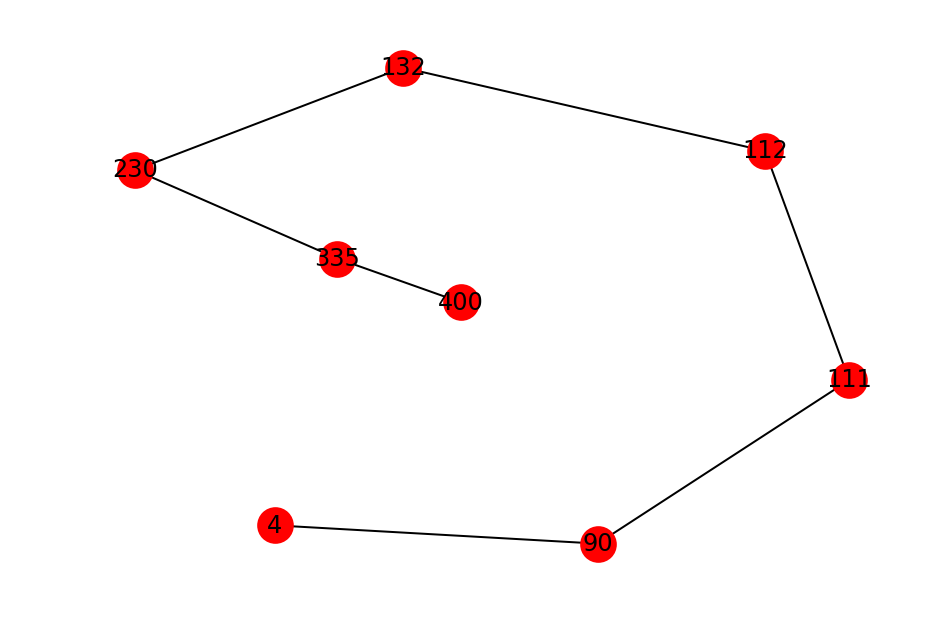

In [38]:
# Possible Answer:

def extract_path_edges(G, source, target):
    # Check to make sure that a path does exists between source and target.
    if nx.has_path(G, source, target):
        nodes = nx.shortest_path(G, source, target)
        newG = G.subgraph(nodes)
        return newG

    else:
        raise Exception('Path does not exist between nodes {0} and {1}.'.format(source, target))
        
newG = extract_path_edges(G, 4, 400)
nx.draw(newG, with_labels=True)

### Challenge Exercise (at home)

These exercises below are designed to let you become more familiar with manipulating and visualizing subsets of a graph's nodes.

Write a function that extracts only node, its neighbors, and the edges between that node and its neighbors as a new graph. Then, draw the new graph to screen.

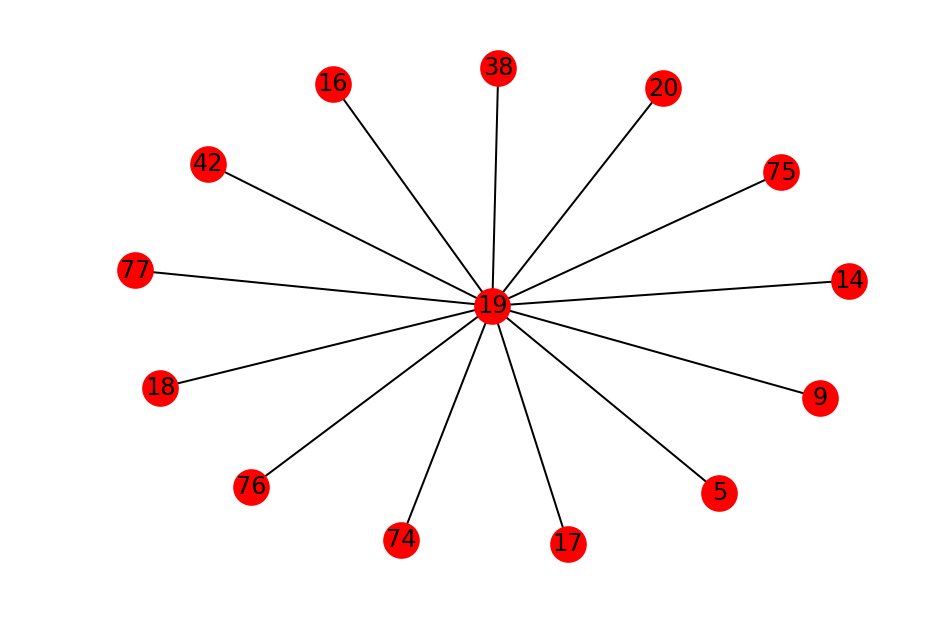

In [39]:
# Possible Answer

def extract_neighbor_edges(G, node):
    neighbors = G.neighbors(node)
    newG = nx.Graph()
    
    for n1, n2 in G.edges():
        if (n1 == node and n2 in neighbors) or (n1 in neighbors and n2 == node):
            newG.add_edge(n1, n2)
            
    return newG

fig = plt.figure(0)
newG = extract_neighbor_edges(G, 19)
nx.draw(newG, with_labels=True)

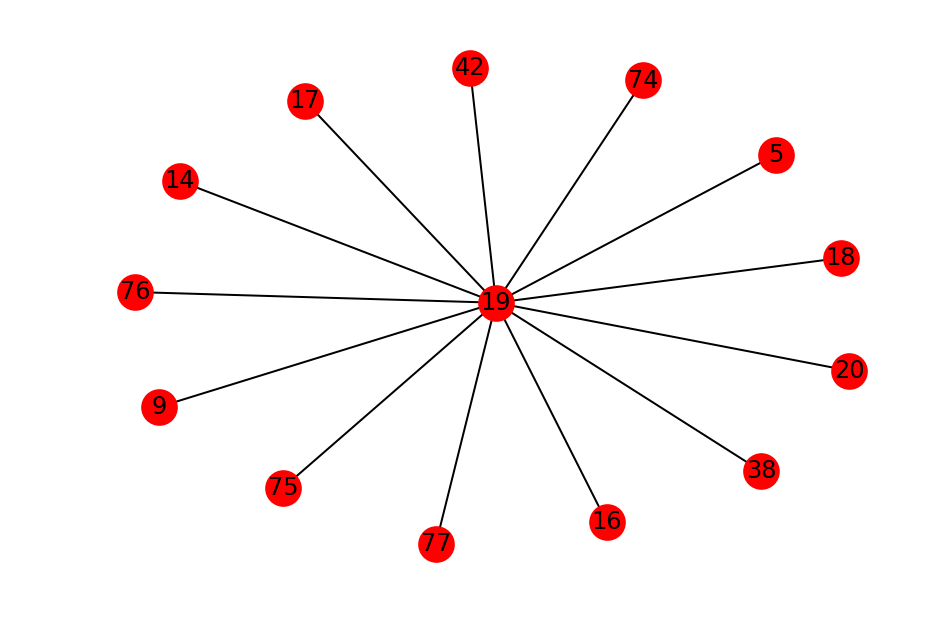

In [40]:
def extract_neighbor_edges2(G, node):
    neighbors = G.neighbors(node)
    newG = nx.Graph()
    
    for neighbor in neighbors:
        if (node, neighbor) in G.edges() or (neighbor, node) in G.edges():
            newG.add_edge(node, neighbor)

    return newG

fig = plt.figure(1)
newG = extract_neighbor_edges2(G, 19)
nx.draw(newG, with_labels=True)

### Challenge Exercises (at home)

Let's try some other problems that build on the NetworkX API. Refer to the following for the relevant functions:

http://networkx.readthedocs.io/en/networkx-1.11/reference/algorithms.shortest_paths.html

1. If we want a message to go from one person to another person, and we assume that the message takes 1 day for the initial step and 1 additional day per step in the transmission chain (i.e. the first step takes 1 day, the second step takes 2 days etc.), how long will the message take to spread from any two given individuals? Write a function to compute this.
2. What is the distribution of message spread times from person to person? What about chain lengths?

In [41]:
# Possible answer to Question 1:
# All we need here is the length of the path.

def compute_transmission_time(G, source, target):
    """
    Fill in code below.
    """
    length = nx.shortest_path_length(G, source, target)
    
    time = sum([i for i in range(1, length+1)])
    
    return time

compute_transmission_time(G, 14, 4)       

3

<Container object of 10 artists>

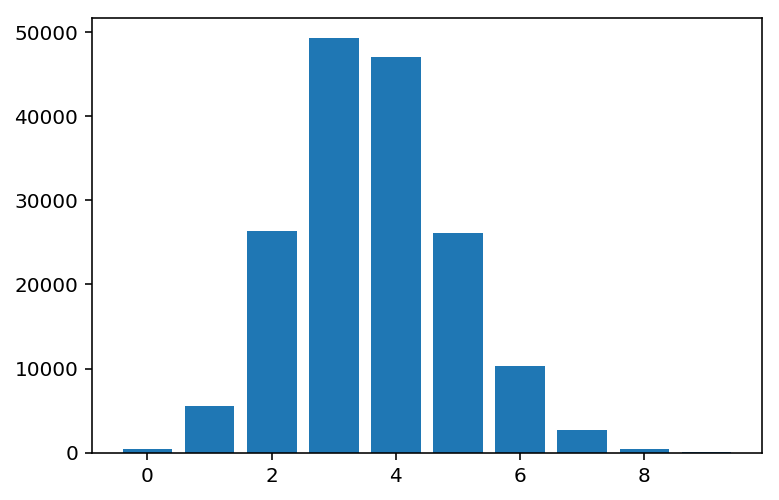

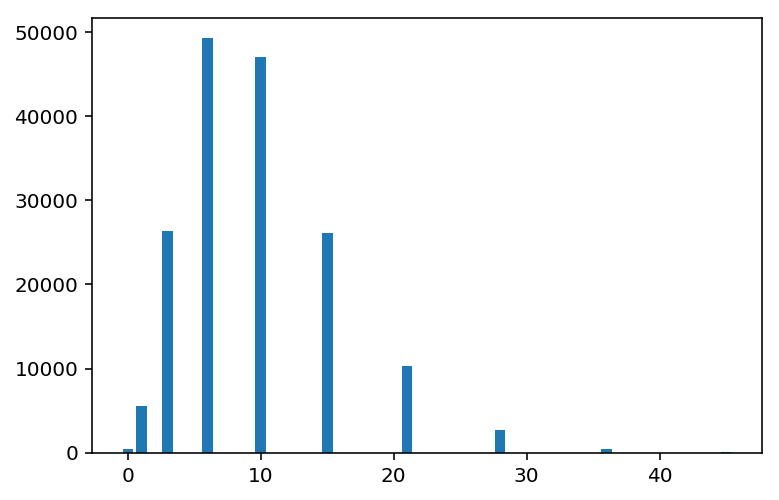

In [42]:
# Possible answer to Question 2:
# We need to know the length of every single shortest path between every pair of nodes.
# If we don't put a source and target into the nx.shortest_path_length(G) function call, then
# we get a dictionary of dictionaries, where all source-->target-->lengths are shown.

lengths = []
times = []
for source, sink_length in nx.shortest_path_length(G).items():
    for sink, length in sink_length.items():
        times.append(sum(range(1, length+1)))
        lengths.append(length)
        
plt.figure(0)
plt.bar(list(Counter(lengths).keys()), list(Counter(lengths).values()))

plt.figure(1)
plt.bar(list(Counter(times).keys()), list(Counter(times).values()))

# Hubs Revisited

If a message has to be passed through the network in the shortest time possible, there may be "bottleneck" nodes through which information must always flow through. Such a node has a high **betweenness centrality**. This is implemented as one of NetworkX's centrality algorithms. Check out the Wikipedia page for a further description.

http://en.wikipedia.org/wiki/Betweenness_centrality

<Container object of 411 artists>

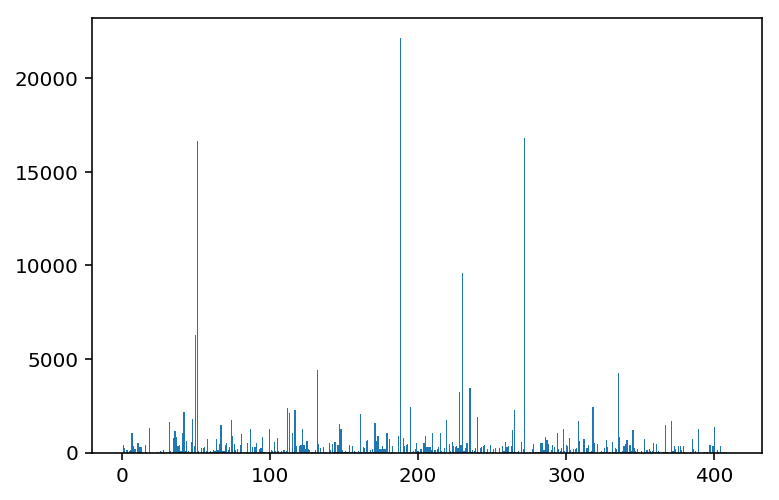

In [43]:
btws = nx.betweenness_centrality(G, normalized=False)
plt.bar(list(btws.keys()), list(btws.values()))

## Exercise

Plot betweeness centrality against degree centrality for the network data. (5 min.)

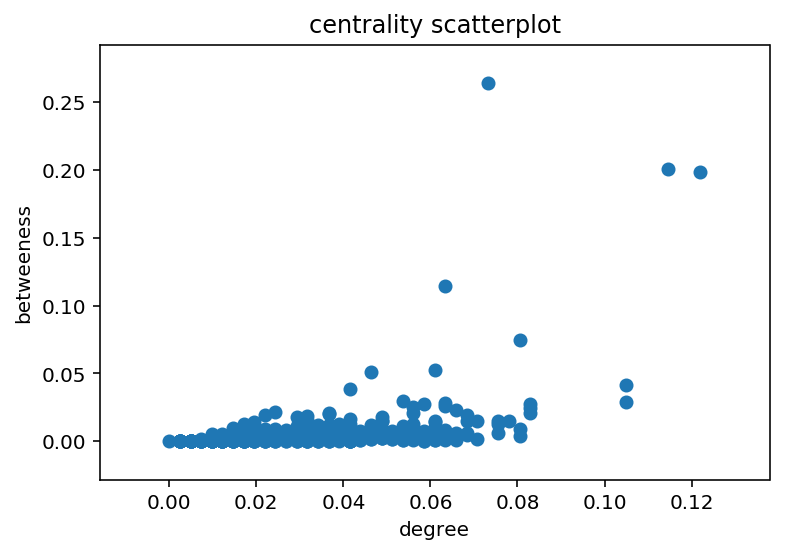

In [44]:
# Possible answer:

deg_centrality = nx.degree_centrality(G)
btw_centrality = nx.betweenness_centrality(G)

deg_cent_sorted = [i[1] for i in sorted(zip(deg_centrality.keys(), deg_centrality.values()))]
btw_cent_sorted = [i[1] for i in sorted(zip(btw_centrality.keys(), btw_centrality.values()))]

plt.scatter(deg_cent_sorted, btw_cent_sorted)
plt.xlabel('degree')
plt.ylabel('betweeness')
plt.title('centrality scatterplot')

**Think about it...**

From the scatter plot, we can see that the dots don't all fall on the same line. Degree centrality and betweenness centrality don't necessarily correlate. Can you think of scenarios where this is true?

What would be the degree centrality and betweenness centrality of the middle connecting node in the **barbell graph** below?

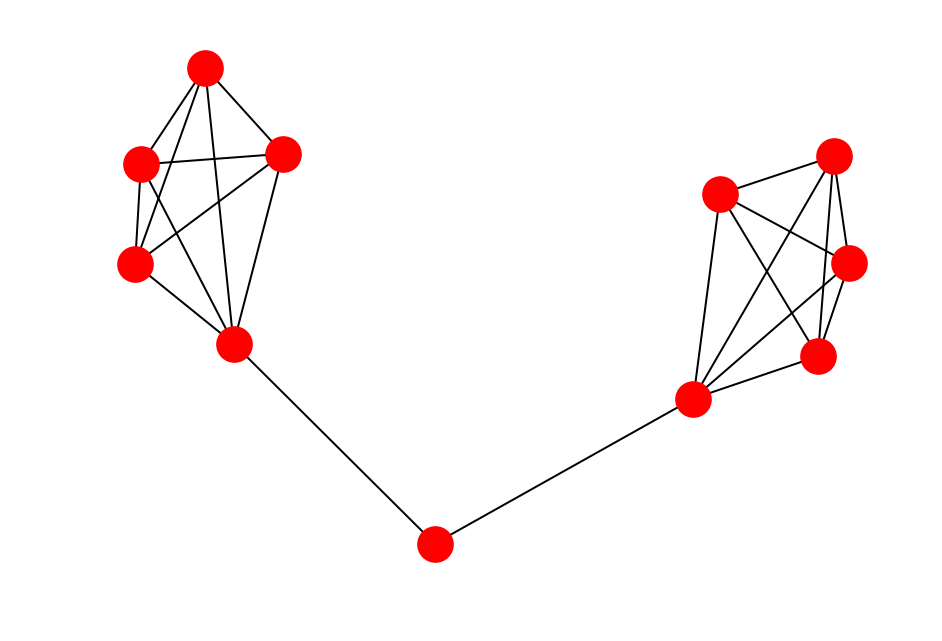

In [45]:
nx.draw(nx.barbell_graph(5, 1))